This notebook explians example of the BERT(Bidirectional Encoder Representations from Transformers) base implementation  using TensorFlow hub. 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow_hub as hub
import tensorflow as tf
import bert_tokenization as tokenization
import tensorflow.keras.backend as K
import gc
import os
from scipy.stats import spearmanr
from math import floor, ceil
from tensorflow.keras.models import load_model
from sklearn.metrics import  confusion_matrix 

**1. Loading data and tokenizer**

Read the train, test data and tokenizer.The maximum sequence length for BERT is 512 and if annything longer than this we have to trim the sequence 

In [62]:
train_path = '../input/google-quest-challenge/train.csv'
test_path = '../input/google-quest-challenge/test.csv'
sub_file_path = '../input/google-quest-challenge/sample_submission.csv'
BERT_path = '../input/bert-base-from-tfhub/bert_en_uncased_L-12_H-768_A-12'
tokenizer = tokenization.FullTokenizer(BERT_path+'/assets/vocab.txt', True)
max_length = 512

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
df_sub_file =  pd.read_csv(sub_file_path)
output_categories = list(train_data.columns[11:])
input_categories = list(test_data.columns[[1,2,5]])
print('\noutput categories:\n\t', output_categories)
print('\ninput categories:\n\t', input_categories)


output categories:
	 ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']

input categories:
	 ['question_title', 'question_body', 'answer']


**2. EDA and visual representation of data**

In [66]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6079 entries, 0 to 6078
Data columns (total 41 columns):
qa_id                                    6079 non-null int64
question_title                           6079 non-null object
question_body                            6079 non-null object
question_user_name                       6079 non-null object
question_user_page                       6079 non-null object
answer                                   6079 non-null object
answer_user_name                         6079 non-null object
answer_user_page                         6079 non-null object
url                                      6079 non-null object
category                                 6079 non-null object
host                                     6079 non-null object
question_asker_intent_understanding      6079 non-null float64
question_body_critical                   6079 non-null float64
question_conversational                  6079 non-null float64
question_expect_short_a

In [67]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 11 columns):
qa_id                 476 non-null int64
question_title        476 non-null object
question_body         476 non-null object
question_user_name    476 non-null object
question_user_page    476 non-null object
answer                476 non-null object
answer_user_name      476 non-null object
answer_user_page      476 non-null object
url                   476 non-null object
category              476 non-null object
host                  476 non-null object
dtypes: int64(1), object(10)
memory usage: 41.0+ KB


In [68]:
#statistical description on train data
train_data.describe()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
count,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,...,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000
mean,4829.665899,0.892663,0.595301,0.057301,0.698525,0.772633,0.793689,0.587478,0.507275,0.238745,...,0.799931,0.925408,0.654823,0.960054,0.968626,0.854680,0.479547,0.130641,0.502468,0.908254
std,2789.689555,0.132047,0.219470,0.182196,0.350938,0.303023,0.336622,0.135900,0.185987,0.335057,...,0.178420,0.114836,0.107666,0.086926,0.074631,0.130743,0.422921,0.225718,0.407097,0.100708
min,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,...,0.333333,0.333333,0.333333,0.333333,0.333333,0.200000,0.000000,0.000000,0.000000,0.333333
25%,2389.000000,0.777778,0.444444,0.000000,0.500000,0.666667,0.666667,0.444444,0.333333,0.000000,...,0.666667,0.888889,0.666667,1.000000,1.000000,0.800000,0.000000,0.000000,0.000000,0.888889
50%,4847.000000,0.888889,0.555556,0.000000,0.666667,1.000000,1.000000,0.555556,0.444444,0.000000,...,0.833333,1.000000,0.666667,1.000000,1.000000,0.866667,0.500000,0.000000,0.500000,0.888889
75%,7222.000000,1.000000,0.777778,0.000000,1.000000,1.000000,1.000000,0.666667,0.666667,0.333333,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.933333,1.000000,0.333333,1.000000,1.000000
max,9647.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


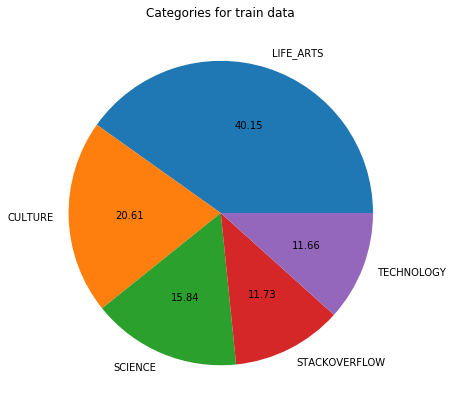

In [69]:
#check and display unique categories in train data
labels = train_data['category'].unique()
pie_data = train_data['category'].value_counts() 
fig = plt.figure(figsize =(10, 7))
plt.title("Categories for train data")
plt.pie(pie_data,labels=labels,autopct='%.2f');

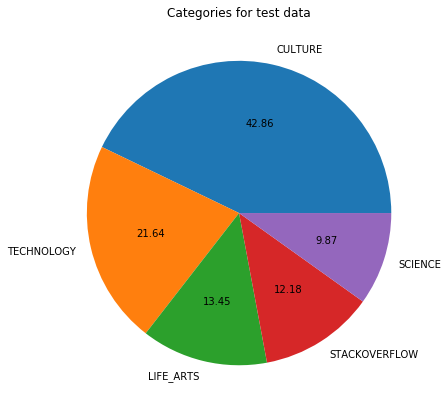

In [70]:
#check and display unique categories in test data
labels = test_data['category'].unique()
pie_data = test_data['category'].value_counts() 
fig = plt.figure(figsize =(10, 7))
plt.title("Categories for test data")
plt.pie(pie_data,labels=labels,autopct='%.2f');

In [71]:
#number of unique questions and question user
train_ques_user = train_data['question_user_name'].unique()
test_ques_user = test_data['question_user_name'].unique()


train_ans_user = train_data['answer_user_name'].unique()
test_ans_user = test_data['answer_user_name'].unique()


print('The unique user in train set',len(train_ques_user))
print('The unique user in test set',len(test_ques_user))
print('\n')
print('The unique user in train set',len(train_ans_user))
print('The unique user in test set',len(test_ans_user))

The unique user in train set 3215
The unique user in test set 467


The unique user in train set 4114
The unique user in test set 363


**3. Processing Functions**

The tokenized inputs needs to be preprocessed and converted into useable Bert inputs.

In [24]:
def _get_masks(tokens, max_seq_length):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def _get_segments(tokens, max_seq_length):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    first_sep = True
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            if first_sep:
                first_sep = False 
            else:
                current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def _get_ids(tokens, tokenizer, max_seq_length):
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def _trim_input(title, question, answer, max_sequence_length, 
                t_max_len=30, q_max_len=239, a_max_len=239):

    t = tokenizer.tokenize(title)
    q = tokenizer.tokenize(question)
    a = tokenizer.tokenize(answer)
    
    t_len = len(t)
    q_len = len(q)
    a_len = len(a)

    if (t_len+q_len+a_len+4) > max_sequence_length:
        
        if t_max_len > t_len:
            t_new_len = t_len
            a_max_len = a_max_len + floor((t_max_len - t_len)/2)
            q_max_len = q_max_len + ceil((t_max_len - t_len)/2)
        else:
            t_new_len = t_max_len
      
        if a_max_len > a_len:
            a_new_len = a_len 
            q_new_len = q_max_len + (a_max_len - a_len)
        elif q_max_len > q_len:
            a_new_len = a_max_len + (q_max_len - q_len)
            q_new_len = q_len
        else:
            a_new_len = a_max_len
            q_new_len = q_max_len
            
            
        if t_new_len+a_new_len+q_new_len+4 != max_sequence_length:
            raise ValueError("New sequence length should be %d, but is %d" 
                             % (max_sequence_length, (t_new_len+a_new_len+q_new_len+4)))
        
        t = t[:t_new_len]
        q = q[:q_new_len]
        a = a[:a_new_len]
    
    return t, q, a

def _convert_to_bert_inputs(title, question, answer, tokenizer, max_sequence_length):
    
    stoken = ["[CLS]"] + title + ["[SEP]"] + question + ["[SEP]"] + answer + ["[SEP]"]

    input_ids = _get_ids(stoken, tokenizer, max_sequence_length)
    input_masks = _get_masks(stoken, max_sequence_length)
    input_segments = _get_segments(stoken, max_sequence_length)

    return [input_ids, input_masks, input_segments]


def compute_input_arays(df, columns, tokenizer, max_sequence_length):
    input_ids, input_masks, input_segments = [], [], []
    for _, instance in tqdm(df[columns].iterrows()):
        t, q, a = instance.question_title, instance.question_body, instance.answer

        t, q, a = _trim_input(t, q, a, max_sequence_length)

        ids, masks, segments = _convert_to_bert_inputs(t, q, a, tokenizer, max_sequence_length)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]


def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

**4. Model Creation**

**bert_model()** contains the actual architecture that will be used to finetune BERT to our dataset.The preprocessed inputs from previous stage is passed to an bert layer and the bert output is passed to an average pooling layer and finally to an output layer of 30 units.

**compute_spearmanr()** is used to compute the competition metric for the training and validation set.

**CustomCallback()** is a class which will compute validation score  and append validation/test predictions after each epoch. This is a inherited class from tf.keras.callbacks.Callback.

**train_and_predict()** In this function, the model is getting trained on training date and predicts outputs as per the training.

In [10]:
def bert_model():
    
    input_word_ids = tf.keras.layers.Input(
        (max_length,), dtype=tf.int32, name='input_word_ids')
    input_masks = tf.keras.layers.Input(
        (max_length,), dtype=tf.int32, name='input_masks')
    input_segments = tf.keras.layers.Input(
        (max_length,), dtype=tf.int32, name='input_segments')
    
    bert_layer = hub.KerasLayer(BERT_path, trainable=True)
   
    _, sequence_output = bert_layer([input_word_ids, input_masks, input_segments])
    
    x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(30, activation="sigmoid")(x)

    model = tf.keras.models.Model(
        inputs=[input_word_ids, input_masks, input_segments], outputs=out)
    
    return model    
        



In [28]:
def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(col_trues, col_pred + np.random.normal(0, 1e-7, col_pred.shape[0])).correlation)
    return np.mean(rhos)
def rho(y_true, y_pred): 
    rhos = tf.constant(0, dtype='float32') 
    for ind in range(30): 
        a = tf.slice(y_true, [0, ind], [-1, 1]) 
        a = tf.reshape(a, [-1]) 
        b = tf.slice(y_pred, [0, ind], [-1, 1]) 
        b = tf.reshape(b, [-1]) 
        rhos = tf.cond(tf.equal(tf.argmax(a), tf.argmin(a)), 
                       lambda: tf.add(rhos, tf.metrics.binary_crossentropy(a, b)), 
                       lambda: tf.add(rhos, tf.py_function(spearmanr, [a, b], Tout=tf.float32))) 
    return tf.divide(rhos, tf.constant(30, 'float32'))

class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, train_data, valid_data, test_data, batch_size=16, fold=None):
        
        self.train_inputs = train_data[0] #
        self.train_outputs = train_data[1] #

        self.valid_inputs = valid_data[0]
        self.valid_outputs = valid_data[1]
        self.test_inputs = test_data
        
        self.batch_size = batch_size
        self.fold = fold
    def on_train_begin(self, logs={}):
        self.train_predictions = [] 
        self.valid_predictions = []
        self.test_predictions = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.train_predictions.append(self.model.predict(self.train_inputs, batch_size=self.batch_size)) 
        rho_train = compute_spearmanr(self.train_outputs, np.average(self.train_predictions, axis=0)) 
        
        self.valid_predictions.append(self.model.predict(self.valid_inputs, batch_size=self.batch_size))
        rho_val = compute_spearmanr(self.valid_outputs, np.average(self.valid_predictions, axis=0))
        print(f"\ntrain rho: %.4f, validation rho: %.4f" % (rho_train, rho_val))
        
        if self.fold is not None:
            self.model.save_weights(f'bert-base-{fold}-{epoch}.h5py')
        
        self.test_predictions.append(
            self.model.predict(self.test_inputs, batch_size=self.batch_size))
    

In [15]:
def train_and_predict(model, train_data, valid_data, test_data, 
                      learning_rate, epochs, batch_size, loss_function, fold):
        
    custom_callback = CustomCallback(train_data=(train_data[0], train_data[1]), #
                                     valid_data=(valid_data[0], valid_data[1]), 
                                     test_data=test_data,
                                     batch_size=batch_size,
                                     fold=None)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss_function, optimizer=optimizer, metrics=[rho])
    history = model.fit(x=train_data[0], y=train_data[1], epochs=epochs, 
                        batch_size=batch_size, validation_data=(valid_data[0], valid_data[1]), callbacks=[custom_callback])
    
    return custom_callback, history

**5. Model training**

We train the created model using train data and validate it using the validation data.

In [37]:
gkf = GroupKFold(n_splits=5).split(X=train_data.question_body, groups=train_data.question_body) 

outputs = compute_output_arrays(train_data, output_categories)
inputs = compute_input_arays(train_data, input_categories, tokenizer, max_length)
test_inputs = compute_input_arays(test_data, input_categories, tokenizer, max_length)

In [38]:
histories = []
custom_callback_histories = []
splits = 5
comp_fold = splits+1
for fold, (train_idx, valid_idx) in enumerate(gkf):
    
    if fold < comp_fold:
        K.clear_session()
        model = bert_model()

        train_inputs = [inputs[i][train_idx] for i in range(len(inputs))]
        train_outputs = outputs[train_idx]

        valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        valid_outputs = outputs[valid_idx]

        custom_callback_history,history = train_and_predict(model, 
                          train_data=(train_inputs, train_outputs), 
                          valid_data=(valid_inputs, valid_outputs),
                          test_data=test_inputs, 
                          learning_rate=3e-5, epochs=5, batch_size=6,
                          loss_function='binary_crossentropy', fold=fold)

        histories.append(history)
        custom_callback_histories.append(custom_callback_history)

Train on 4863 samples, validate on 1216 samples
Epoch 1/5
4860/4863 [============================>.] - ETA: 0s - loss: 0.3950 - rho: 0.2381
train rho: 0.4171, validation rho: 0.3646
4863/4863 [==============================] - 568s 117ms/sample - loss: 0.3949 - rho: 0.2383 - val_loss: 0.3792 - val_rho: 0.3131
Epoch 2/5
4860/4863 [============================>.] - ETA: 0s - loss: 0.3645 - rho: 0.3278
train rho: 0.4652, validation rho: 0.3809
4863/4863 [==============================] - 537s 110ms/sample - loss: 0.3645 - rho: 0.3277 - val_loss: 0.3761 - val_rho: 0.3274
Epoch 3/5
4860/4863 [============================>.] - ETA: 0s - loss: 0.3469 - rho: 0.3821
train rho: 0.5140, validation rho: 0.3876
4863/4863 [==============================] - 536s 110ms/sample - loss: 0.3469 - rho: 0.3822 - val_loss: 0.3734 - val_rho: 0.3242
Epoch 4/5
4860/4863 [============================>.] - ETA: 0s - loss: 0.3269 - rho: 0.4413
train rho: 0.5705, validation rho: 0.3913
4863/4863 [==================

In [44]:
def metricsplot(histories, metric):
    fig = plt.figure(figsize=(7*2, 6*ceil(len(histories)/2)))
    fig.set_facecolor("#F3F3F3")
    for n in range(len(histories)):
        qx = plt.subplot(ceil(len(histories)/2), 2, n+1)
        plt.plot(list(range(1, len(histories[n].history[metric])+1)), histories[n].history[metric], 'b', linestyle = "dotted", linewidth = 2, 
                 label='Training '+metric)
        plt.plot(list(range(1, len(histories[n].history['val_'+metric])+1)), histories[n].history['val_'+metric], 'b', linewidth = 2, label='Validation '+metric)
        plt.legend(prop = {"size" : 12})
        plt.grid(True, alpha = .15)
        plt.title('Training and validation '+ metric + ' on fold_{%d}' %(n))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.xticks(list(range(1, len(histories[n].history[metric])+1)))

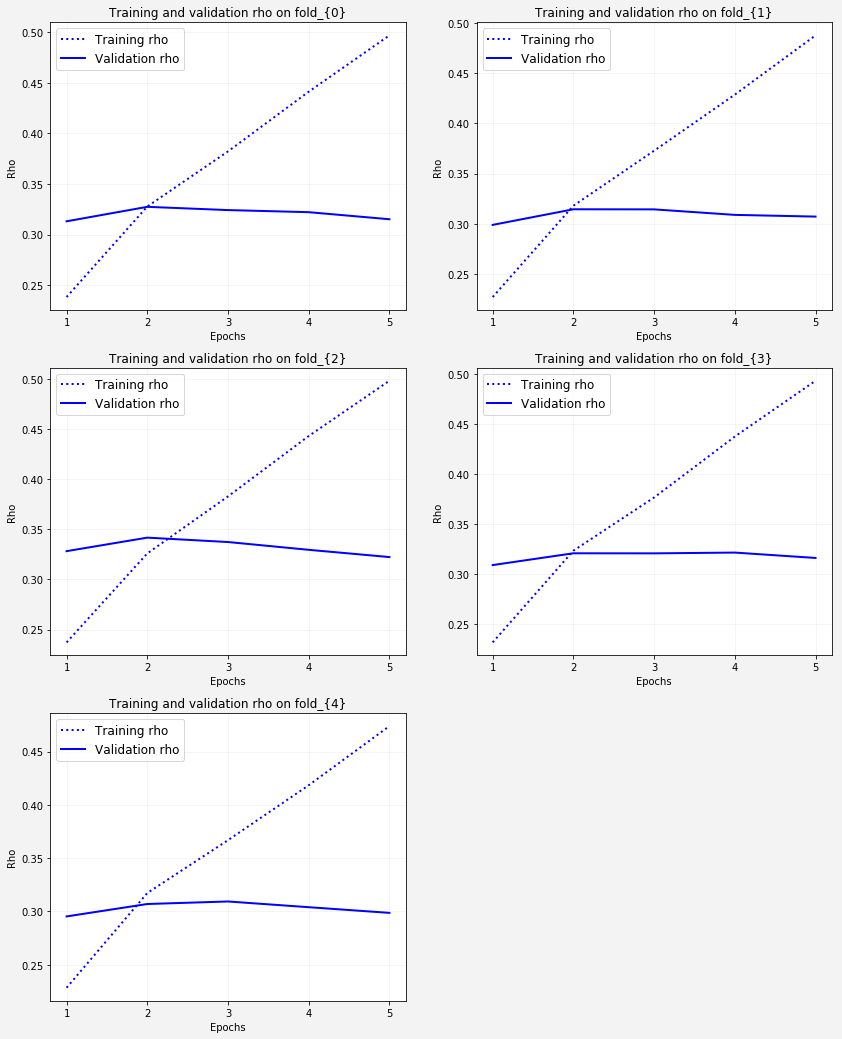

In [45]:
metricsplot(histories, 'rho')

**6. Model predictions**

Pass the test data to the newly created model for predicting outputs.

In [58]:
test_predictions = [custom_callback_histories[i].test_predictions for i in range(len(custom_callback_histories))]
test_predictions = [np.average(test_predictions[i], axis=0) for i in range(len(test_predictions))]
test_predictions = np.mean(test_predictions, axis=0)


In [63]:
df_sub_file.iloc[:, 1:] = test_predictions

df_sub_file.to_csv('submission.csv', index=False)

In [64]:
df_sub_file.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.933205,0.624182,0.165076,0.505388,0.567624,0.588050,0.666570,0.605348,0.600776,...,0.905107,0.899641,0.571734,0.959795,0.957652,0.781466,0.076793,0.041864,0.853540,0.909792
1,46,0.881093,0.487951,0.006636,0.793985,0.792305,0.926216,0.538581,0.451360,0.115441,...,0.703359,0.951282,0.655378,0.969981,0.981661,0.878151,0.914335,0.119439,0.102150,0.902067
2,70,0.910676,0.622830,0.024263,0.774779,0.861138,0.931691,0.595618,0.472179,0.228696,...,0.867417,0.918114,0.586317,0.959739,0.963946,0.815928,0.095375,0.058735,0.847738,0.899331
3,132,0.871987,0.437642,0.006624,0.739246,0.763010,0.916973,0.545876,0.420713,0.089171,...,0.706639,0.935427,0.666097,0.967204,0.981920,0.883474,0.827497,0.143457,0.465060,0.897364
4,200,0.923424,0.396127,0.034959,0.852946,0.715416,0.852034,0.661973,0.583643,0.093936,...,0.708058,0.916875,0.656576,0.960085,0.965328,0.817184,0.193673,0.110372,0.598587,0.908896
